In [1]:
from Env import DiskEnv
from DQN_torch import DQN
from ReplayBuffer import ReplayBuffer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import seaborn as sns

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
num_actions = 128*128
env = DiskEnv(size=128, num_actions=num_actions)
env_width, env_height = 128, 128
grid_size = int(np.sqrt(num_actions))  # Assuming a square grid

In [3]:
feature_embedding_size = 128  # Size of the feature embedding tensor
metadata_size = 2  # Size of the metadata tensor (e.g., radius and number of disks)

model = DQN(feature_embedding_size, metadata_size, num_actions).to(device)
model_target = DQN(feature_embedding_size, metadata_size, num_actions).to(device)
model_target.load_state_dict(model.state_dict())
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(initialize_weights)
# model_target.apply(initialize_weights)
model

DQN(
  (conv1): Conv2d(1, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_combined): Linear(in_features=9218, out_features=2048, bias=True)
  (policy_fc): Linear(in_features=2048, out_features=2048, bias=True)
  (policy_net): Sequential(
    (0): ReLU()
    (1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

TODO

In [4]:
# Define other parameters and hyperparameters
gamma = 0.99
# epsilon = 1.0
# epsilon_min = 0.1
# epsilon_max = 1.0
# epsilon_interval = epsilon_max - epsilon_min
batch_size = 64
max_steps_per_episode = 500
initial_replay_buffer_size = 1000
max_replay_buffer_size = 30000
replay_buffer = ReplayBuffer(device, initial_size=initial_replay_buffer_size, max_size=max_replay_buffer_size, grid_size=grid_size)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#mse_loss = nn.MSELoss()
def ppo_loss(old_policy, new_policy, advantages, epsilon=0.2):
    """
    Compute the PPO clipped loss.

    Parameters:
    - old_policy: The old policy logits.
    - new_policy: The new policy logits.
    - advantages: The advantage estimates.
    - epsilon: The clipping parameter.

    Returns:
    - loss: The PPO clipped loss.
    """
    ratio = torch.exp(new_policy - old_policy)
    clipped_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
    loss = torch.min(ratio * advantages, clipped_ratio * advantages)
    return -loss.mean()
def compute_entropy(policy_output):
    """
    Compute the entropy of the policy's action distribution.

    Parameters:
    - policy_output: The policy logits.

    Returns:
    - entropy: The entropy of the policy's action distribution.
    """
    policy_probs = F.softmax(policy_output, dim=-1)
    entropy = -(policy_probs * torch.log(policy_probs + 1e-6)).sum(dim=-1).mean()
    return entropy

running_reward = 0
episode_count = 0
frame_count = 0
# epsilon_random_frames = 2000
# epsilon_greedy_frames = 100000.0
update_target_network = 5000

action_counts = defaultdict(int)
reward_history = []
num_disks_history = []
radius_history = []
coverage_history = []
average_rewards = []
losses = []
episode_frame_count = 0
max_grad_norm = 1.0
entropy_coefficient = 0.5

In [5]:
def create_mask(states: torch.Tensor, radii: torch.Tensor, num_actions: int, grid_size: int, device: torch.device) -> torch.Tensor:
    """
    Create a mask for invalid actions based on the current state.

    Parameters:
    - states: The current state tensor of shape (batch_size, 1, grid_size, grid_size).
    - radii: The radii of the disks for each state.
    - num_actions: The number of possible actions.
    - grid_size: The size of the grid.
    - device: The device to run the tensor operations on.

    Returns:
    - mask: A tensor of shape (batch_size, num_actions) with -inf for invalid actions and 0 for valid actions.
    """
    batch_size = states.size(0)
    mask = torch.zeros((batch_size, num_actions), device=device)

    min_squared_distances = (2 * radii.view(batch_size, 1)) ** 2

    # Create action indices
    action_indices = torch.arange(num_actions, device=device).view(1, -1)
    x_coords = (action_indices % grid_size).float()
    y_coords = (action_indices // grid_size).float()

    for i in range(batch_size):
        state = states[i, 0]
        filled_positions = (state == 1).nonzero(as_tuple=False)

        if filled_positions.numel() == 0:
            continue

        x_filled = filled_positions[:, 0].float().unsqueeze(1)
        y_filled = filled_positions[:, 1].float().unsqueeze(1)

        dx = torch.min(torch.abs(x_filled - x_coords), grid_size - torch.abs(x_filled - x_coords))
        dy = torch.min(torch.abs(y_filled - y_coords), grid_size - torch.abs(y_filled - y_coords))
        squared_distances = dx ** 2 + dy ** 2

        invalid_actions = torch.any(squared_distances < min_squared_distances[i], dim=0)
        mask[i, invalid_actions] = -1

    return mask

# batch_size = 2
# grid_size = 10
# num_actions = grid_size * grid_size

# # Create dummy states with some filled positions
# states = torch.zeros((batch_size, 1, grid_size, grid_size), device=device)
# states[0, 0, 5, 5] = 1
# # states[0, 0, 4, 4] = 1
# # states[1, 0, 1, 1] = 1
# # states[1, 0, 6, 6] = 1

# # Create dummy radii
# radii = torch.tensor([2.0, 3.0], device=device)

# # Call create_mask function
# mask = create_mask(states, radii, num_actions, grid_size, device)
# def print_mask_in_grid_format(mask: torch.Tensor, grid_size: int) -> None:
#     """
#     Print the mask in a squared view.

#     Parameters:
#     - mask: The mask tensor of shape (batch_size, num_actions).
#     - grid_size: The size of the grid.
#     """
#     batch_size, num_actions = mask.shape
#     for i in range(batch_size):
#         print(f"Mask for batch {i}:")
#         mask_2d = mask[i].view(grid_size, grid_size).cpu().numpy()
#         for row in mask_2d:
#             print("     ".join(f"{int(val):4}" for val in row))
#         print("\n")
# print("Mask:", mask.shape)
# print_mask_in_grid_format(mask, grid_size)

def read_best_reward_from_file(file_path: str) -> float:
    try:
        with open(file_path, 'r') as file:
            best_reward = float(file.read().strip())
    except FileNotFoundError:
        best_reward = 0.0  # Default value if the file does not exist
    except ValueError:
        best_reward = 0.0  # Default value if the file content is not a valid number
    return best_reward

def update_best_reward_in_file(file_path: str, best_reward: float) -> None:
    with open(file_path, 'w') as file:
        file.write(str(best_reward))

defaultdict(<class 'int'>, {1862: 546})
Episode 6, Frame Count: 546 / 3046,
Average Reward: 1.764,
Memory Length: 1001, Radius: 4,
Current Coverage: 0.00, Target Coverage: 0.45



C:\Users\Coartix\AppData\Local\Temp\ipykernel_93028\2683750591.py:136: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_actions, bw_adjust=0.5)


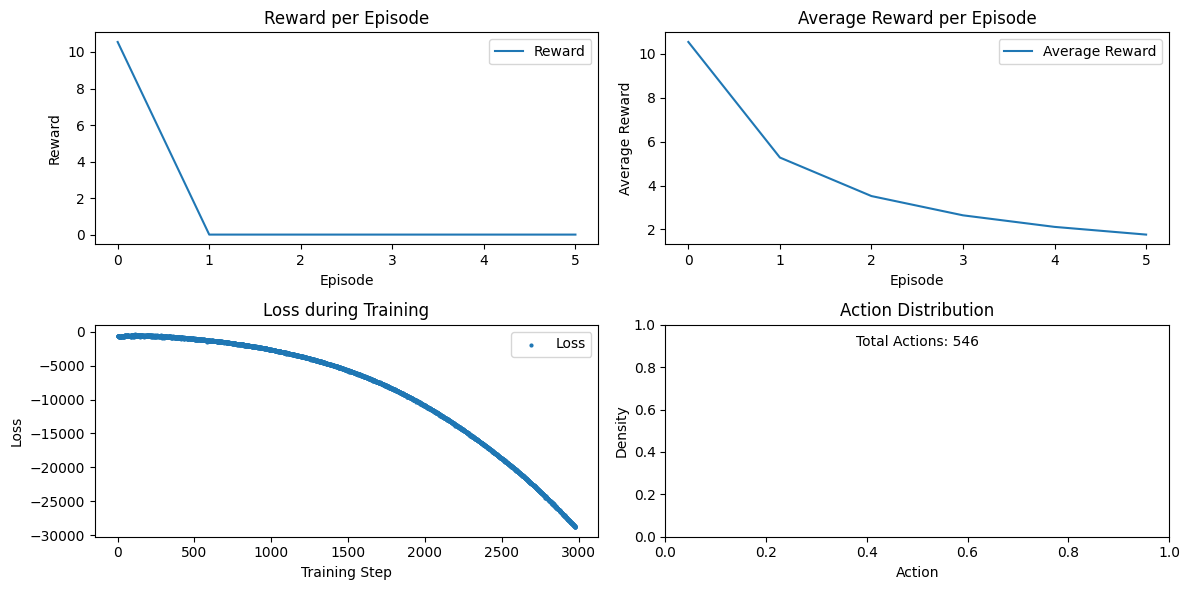

defaultdict(<class 'int'>, {1862: 500})
Episode 7, Frame Count: 500 / 3546,
Average Reward: 1.513,
Memory Length: 1001, Radius: 4,
Current Coverage: 0.00, Target Coverage: 0.45



C:\Users\Coartix\AppData\Local\Temp\ipykernel_93028\2683750591.py:136: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(all_actions, bw_adjust=0.5)


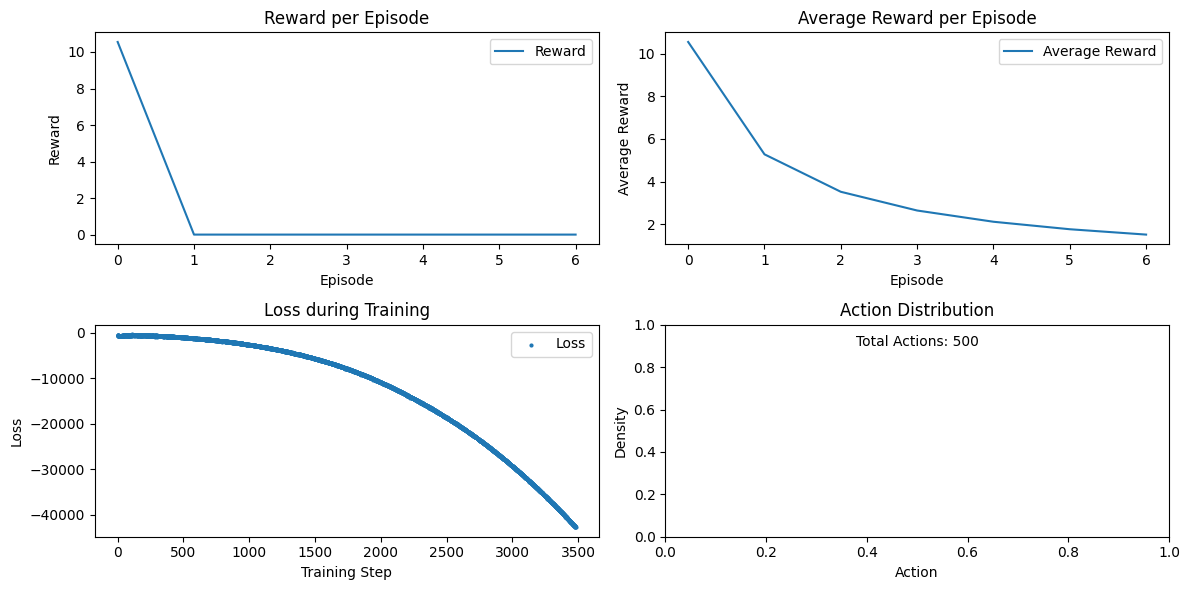

KeyboardInterrupt: 

: 

In [7]:
best_avg_reward = read_best_reward_from_file('best_reward.txt')
while True:  # Training loop
    coordinates = env.reset()
    radius = env.radius
    num_disks = env.num_disks
    state = env.get_state()
    state = np.expand_dims(state, axis=0)  # Convert (grid_size, grid_size, 1) to (1, grid_size, grid_size, 1)
    state = np.transpose(state, (0, 3, 1, 2))  # Convert to (1, 1, grid_size, grid_size)
    episode_reward = 0

    for timestep in range(max_steps_per_episode):
        frame_count += 1

        with torch.no_grad():
            state_tensor = torch.tensor(state).float().to(device)
            metadata_tensor = torch.tensor([radius, num_disks]).float().to(device).unsqueeze(0)
            policy_output, value_output = model(state_tensor, metadata_tensor)
            action_probs = torch.softmax(policy_output, dim=1)
            action_distribution = torch.distributions.Categorical(action_probs)
            action_index = action_distribution.sample().item()
            action_counts[action_index] += 1

        x = int((action_index % grid_size) * (env_width / grid_size))
        y = int((action_index // grid_size) * (env_height / grid_size))
        action = (x, y)
        next_coordinates, reward, done = env.step(action)
        next_state = env.get_state()
        next_state = np.expand_dims(next_state, axis=0)  # Convert (grid_size, grid_size, 1) to (1, grid_size, grid_size, 1)
        episode_reward += math.sqrt(reward) / num_disks

        replay_buffer.add(state, action_index, reward, next_state, done, radius)

        if len(replay_buffer) > batch_size:
            states, actions, rewards, next_states, dones, radii = replay_buffer.sample(batch_size)
            num_disks_batch = torch.tensor([num_disks] * batch_size).float().to(device)
            metadata_batch = torch.stack((radii, num_disks_batch), dim=1)

            ''' Proximal policy optimization '''
            # Compute old policy logits
            with torch.no_grad():
                old_policy_output, _ = model(states, metadata_batch)

            # Compute new policy logits and value output
            policy_output, value_output = model(states, metadata_batch)

            # Apply masking
            mask = create_mask(states, radii, num_actions, grid_size, device)
            masked_policy_output = policy_output + mask
            masked_old_policy_output = old_policy_output + mask

            # Compute probabilities for actions taken
            action_probs = torch.gather(masked_policy_output, 1, actions.unsqueeze(-1)).squeeze(-1)
            old_action_probs = torch.gather(masked_old_policy_output, 1, actions.unsqueeze(-1)).squeeze(-1)

            # Compute target values
            next_policy_output, _ = model_target(next_states, metadata_batch)
            next_mask = create_mask(next_states, radii, num_actions, grid_size, device)
            next_masked_policy_output = next_policy_output + next_mask

            next_action_probs = torch.max(next_masked_policy_output, 1)[0].detach()
            target_values = rewards + gamma * next_action_probs * (1 - dones)

            # Compute advantages
            advantages = target_values - value_output.squeeze()
            # Compute PPO loss
            loss = ppo_loss(old_action_probs, action_probs, advantages)
            entropy = compute_entropy(policy_output)
            loss -= entropy_coefficient * entropy

            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # gradient clipping
            optimizer.step()

        if frame_count % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())
        if done:
            break

    episode_count += 1
    reward_history.append(episode_reward)
    num_disks_history.append(num_disks)
    radius_history.append(radius)
    episode_coverage = len(env.circle_centers) * np.pi * radius ** 2 / (env_width * env_height)
    coverage_history.append(episode_coverage)
    average_reward = np.mean(reward_history[-10:])
    average_rewards.append(average_reward)
    
    print(f'Episode {episode_count}, Frame Count: {frame_count - episode_frame_count} / {frame_count},\n'
        f'Average Reward: {average_reward:.3f},\n'
        f'Memory Length: {len(replay_buffer)}, Radius: {env.radius},\n'
        f'Current Coverage: {episode_coverage:.2f}, Target Coverage: {env.target_coverage:.2f}\n')
    episode_frame_count = frame_count
    
    if average_reward > best_avg_reward:
        torch.save(model_target.state_dict(), 'models/best_model_target.pth')
        torch.save(model.state_dict(), 'models/best_model.pth')
        best_avg_reward = average_reward
        update_best_reward_in_file('best_reward.txt', best_avg_reward)

    if episode_count % 1 == 0:
        #env.render()
        # Plot reward history
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.plot(reward_history, label='Reward')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Reward per Episode')
        plt.legend()

        # Plot average reward history
        plt.subplot(2, 2, 2)
        plt.plot(average_rewards, label='Average Reward')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.title('Average Reward per Episode')
        plt.legend()

        # Plot loss history
        plt.subplot(2, 2, 3)
        plt.scatter(range(len(losses)), losses, label='Loss', s=4)
        plt.xlabel('Training Step')
        plt.ylabel('Loss')
        plt.title('Loss during Training')
        plt.legend()

        # Plot action distribution
        plt.subplot(2, 2, 4)
        all_actions = []
        for action, count in action_counts.items():
            all_actions.extend([action] * count)
        sns.kdeplot(all_actions, bw_adjust=0.5)
        plt.xlabel('Action')
        plt.ylabel('Density')
        plt.title('Action Distribution')
        total_actions = sum(action_counts.values())
        plt.text(0.5, plt.ylim()[1] * 0.9, f'Total Actions: {total_actions}', ha='center')
        # Reset action counts
        action_counts = defaultdict(int)

        plt.tight_layout()
        plt.show()

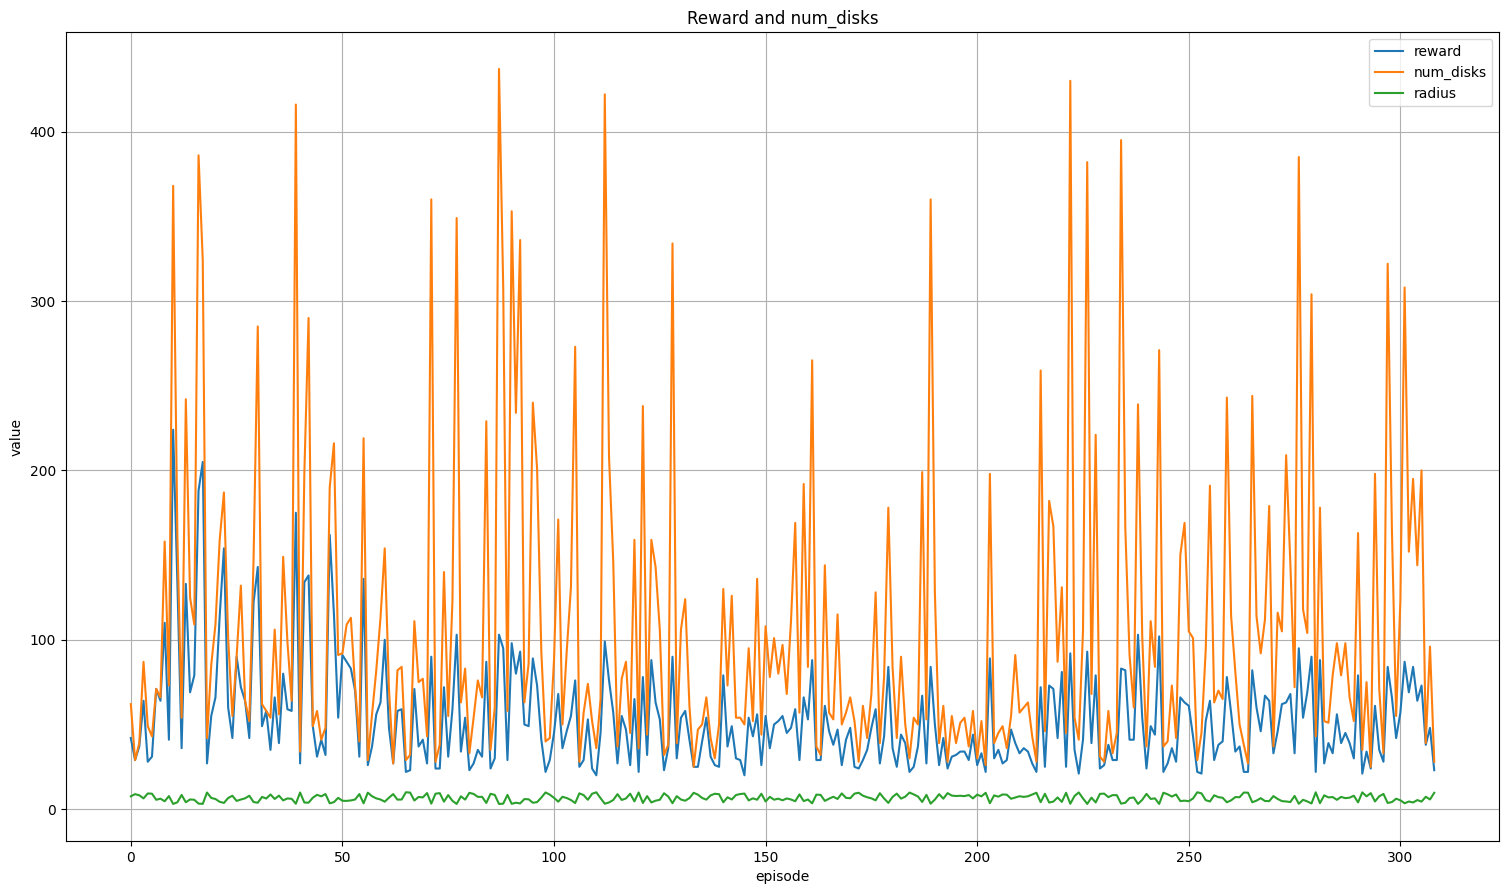

In [ ]:
# Show the reward with num_disks history on same plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(reward_history, label='reward')
ax.plot(num_disks_history, label='num_disks')
ax.plot(radius_history, label='radius')

ax.set(xlabel='episode', ylabel='value',
         title='Reward and num_disks')
ax.grid()
ax.legend()
plt.show()

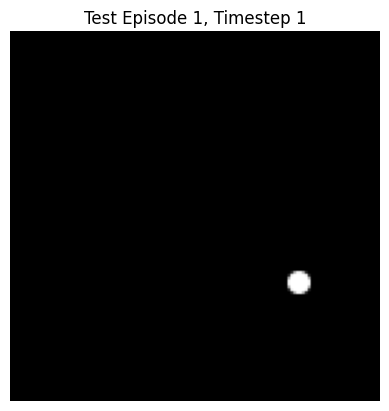

Test Episode 1, Reward: 0.00684931506849315


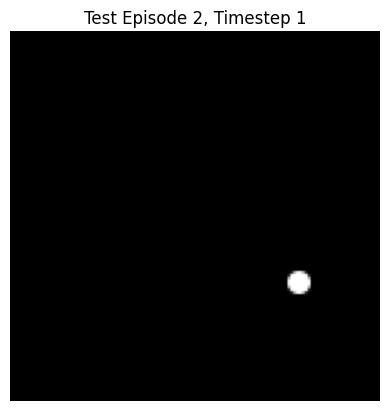

Test Episode 2, Reward: 0.00684931506849315


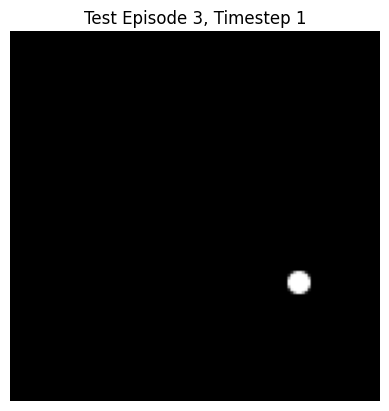

Test Episode 3, Reward: 0.00684931506849315


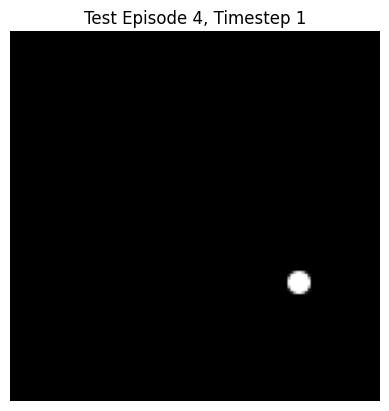

Test Episode 4, Reward: 0.00684931506849315


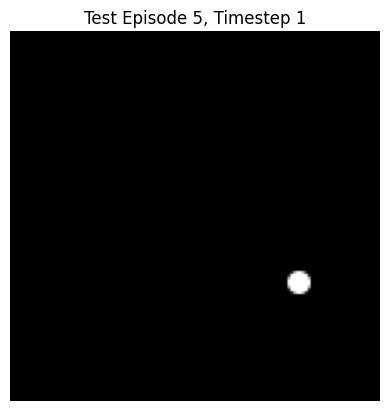

Test Episode 5, Reward: 0.00684931506849315


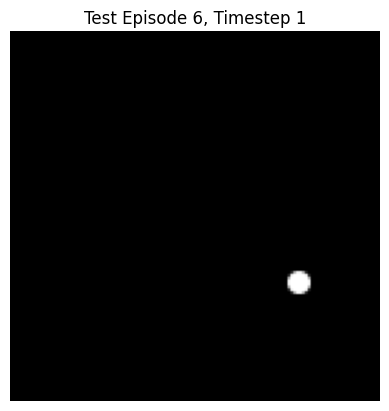

Test Episode 6, Reward: 0.00684931506849315


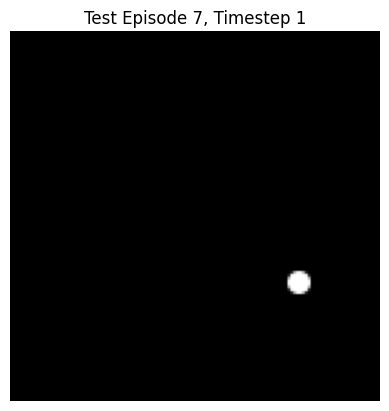

Test Episode 7, Reward: 0.00684931506849315


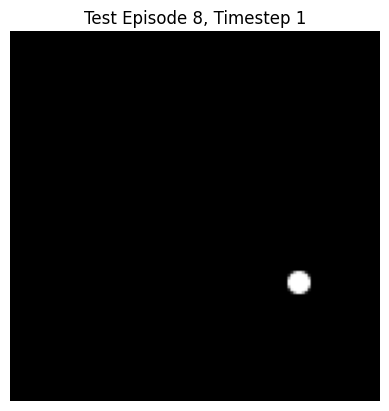

Test Episode 8, Reward: 0.00684931506849315


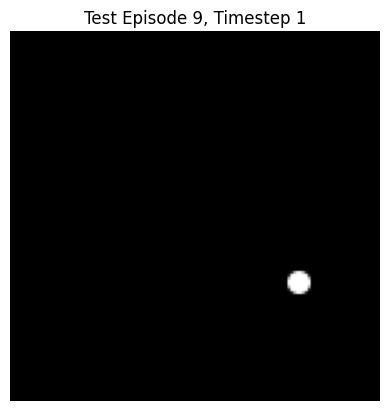

KeyboardInterrupt: 

In [ ]:
model_target.eval()

test_env = DiskEnv(size=grid_size)
test_episodes = 10  # Number of test episodes
test_rewards = []

for episode in range(test_episodes):
    coordinates = test_env.reset()
    radius = test_env.radius
    num_disks = test_env.num_disks
    state = test_env.get_state()
    state = np.expand_dims(state, axis=0)  # Convert (grid_size, grid_size, 1) to (1, grid_size, grid_size, 1)
    state = np.transpose(state, (0, 3, 1, 2))  # Convert to (1, 1, grid_size, grid_size)
    episode_reward = 0

    for timestep in range(max_steps_per_episode):
        with torch.no_grad():
            state_tensor = torch.tensor(state).float().to(device)
            metadata_tensor = torch.tensor([radius, num_disks]).float().to(device).unsqueeze(0)
            policy_output, _ = model_target(state_tensor, metadata_tensor)
            action_index = torch.argmax(policy_output, axis=1).item()

        x = int((action_index % grid_size) * (env_width / grid_size))
        y = int((action_index // grid_size) * (env_height / grid_size))
        action = (x, y)
        next_coordinates, reward, done = test_env.step(action)
        next_state = test_env.get_state()
        next_state = np.expand_dims(next_state, axis=0)  # Convert (grid_size, grid_size, 1) to (1, grid_size, grid_size, 1)
        next_state = np.transpose(next_state, (0, 3, 1, 2))  # Convert to (1, 1, grid_size, grid_size)

        episode_reward += math.sqrt(reward) / num_disks
        if reward > 0:
            test_env.render(title=f"Test Episode {episode + 1}, Timestep {timestep + 1}")

        coordinates = next_coordinates
        state = next_state
        if done:
            break

    test_rewards.append(episode_reward)
    print(f'Test Episode {episode + 1}, Reward: {episode_reward}')

# Plot test rewards
plt.figure(figsize=(10, 5))
plt.plot(test_rewards, label='Test Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Test Reward per Episode')
plt.legend()
plt.show()